In [1]:
from time import time

import numpy as np
import scipy.linalg as la
import sympy as sp

# from numba import jit

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [3]:
a = sp.Symbol("a")
lat = np.array([[0, a, a], [a, 0, a], [a, a, 0]])
nlat = (lat / a).astype(int)
lat

array([[0, a, a],
       [a, 0, a],
       [a, a, 0]], dtype=object)

In [4]:
# inverse lattice
nilat = la.inv(nlat)
ilat = 1 / a * nilat

In [5]:
sm = 2 * np.array([[-1, 2, 2], [2, -1, 2], [2, 2, -1]])
print(sm)
Ntarget = int(la.det(sm))
print(Ntarget)

[[-2  4  4]
 [ 4 -2  4]
 [ 4  4 -2]]
216


In [6]:
# superlattice
slat = sm.dot(lat)
nslat = (slat / a).astype(int)
print(slat[:, :])

[[8*a 2*a 2*a]
 [2*a 8*a 2*a]
 [2*a 2*a 8*a]]


In [7]:
# inverse superlattice
nislat = la.inv(nslat)
islat = nislat / a
islat, nislat

(array([[0.138888888888889/a, -0.0277777777777778/a,
         -0.0277777777777778/a],
        [-0.0277777777777778/a, 0.138888888888889/a,
         -0.0277777777777778/a],
        [-0.0277777777777778/a, -0.0277777777777778/a,
         0.138888888888889/a]], dtype=object),
 array([[ 0.13888889, -0.02777778, -0.02777778],
        [-0.02777778,  0.13888889, -0.02777778],
        [-0.02777778, -0.02777778,  0.13888889]]))

#### Fractional coordinates

In [8]:
rf1 = np.array([0, 0, 0])
rf2 = np.array([1 / 4, 1 / 4, 1 / 4])

#### Cartesian coordinates

In [9]:
rc1 = rf1.dot(lat)
rc2 = rf2.dot(lat)
rc2

array([0.5*a, 0.5*a, 0.5*a], dtype=object)

In [10]:
sm.dot(lat[:, 0])

array([8*a, 2*a, 2*a], dtype=object)

In [11]:
sm.dot(rc2)

array([3.0*a, 3.0*a, 3.0*a], dtype=object)

### Algorithm
1. Construct lattice points
2. Check if lattice point lies within supercell
3. Check if lattice point was found. before, if yes, discard.

#### Criterion for inside/outside the cell
1. Find fractional coord.s of atoms in new basis vectors,
2. discard atoms that have fractional components with
$$ \tilde r_i < 0 ,$$
or
$$ \tilde r_i \geq 1 $$

In [12]:
# collect atomic positions:
R = [rc1, rc2]

In [13]:
new_atoms = []
new_atoms_frac = []

In [14]:
# generate new atoms and append if they lie in the supercell
eps = 1e-5

# @jit(nopython=True)
def inlist(elem, lis, tol=1e-5):
    for ii in range(len(lis)):
        ll = lis[ii]
        # Check length
        na = np.linalg.norm(elem)
        nb = np.linalg.norm(ll)
        if abs(na - nb) > tol:
            continue
        # Check for zero vector
        if abs(na) + abs(nb) < tol:
            return True
        # Check angle
        if abs(np.dot(ll, elem) / na / nb - 1) < tol:
            return True
    #
    # if nothing found:
    return False


def bruteforce(basis, lat, smatrix, checklist=False, verbose=False, tol=1e-5):
    # first find lattice points
    # List of lattice points:

    slat = np.dot(smatrix, lat)
    islat = la.inv(slat).T

    max1 = abs(smatrix[0, :]).max() * 2 + 1
    max2 = abs(smatrix[1, :]).max() * 2 + 1
    max3 = abs(smatrix[2, :]).max() * 2 + 1

    # maximal distance = diagonal
    dmax = np.linalg.norm(slat[:, 0] + slat[:, 1] + slat[:, 2]) + 2
    print(dmax)

    lps = -np.ones((Ntarget, 3), dtype=float)
    flps = -np.ones((Ntarget, 3), dtype=float)

    counter = 0
    for n1 in range(-max1, max1):
        if verbose:
            print("Progress = {}".format((n1 + max1) / (2 * max1)))
        for n2 in range(-max2, max2):
            for n3 in range(-max3, max3):
                # lattice point
                # print(n1, n2, n3)
                lp = (n1 * lat[0] + n2 * lat[1] + n3 * lat[2]).astype(float)

                # Check if this one is relevant
                if np.linalg.norm(lp) > dmax:
                    continue
                #
                # Check if is in list
                if checklist:
                    if counter > 1:
                        if inlist(lp, lps[:counter]):
                            print("lp: {} already in list".format(lp))
                            continue

                # fractional lattice point
                flp = (islat.dot(lp)).astype(float)
                # Check if is inside supercell:
                if any(np.array(flp) < -tol):
                    # print(f'{flp} discarded < 0')
                    continue
                if any(np.array(flp) > 1 - tol):
                    # print(f'{flp} discarded > 1')
                    continue
                #
                # if passed:
                # print('{} accepted'.format(flp))
                lps[counter] = lp
                flps[counter] = flp
                counter += 1
    #
    print("{} lattice points found".format(counter))
    # print('{} of them within supercell'.format(len(flps)))
    return lps, flps, counter

In [15]:
print(nlat, nslat)
stime = time()
lps, flps, counter = bruteforce(R, nlat, sm)
print(f"Finished in {time()-stime:7.2f}s")

[[0 1 1]
 [1 0 1]
 [1 1 0]] [[8 2 2]
 [2 8 2]
 [2 2 8]]
22.784609690826528
216 lattice points found
Finished in    0.03s


In [16]:
lps[:10]

array([[4., 1., 1.],
       [6., 2., 2.],
       [7., 3., 2.],
       [7., 2., 3.],
       [8., 3., 3.],
       [0., 0., 0.],
       [2., 1., 1.],
       [3., 2., 1.],
       [3., 1., 2.],
       [4., 2., 2.]])

In [17]:
# new_atoms_frac

In [18]:
# check if number of atom is correct
print(f"Number of atoms in the supercell is")
print(f"  {int(la.det(sm))} = {len(lps)}")
if int(la.det(sm) == len(lps)):
    print(f"..correct.")
else:
    print(f"..wrong!")

Number of atoms in the supercell is
  216 = 216
..correct.


## Plot
Plot the old and new cells with positions

In [19]:
# old positions as number
nR = [(pos / a).astype(float) for pos in R]

In [20]:
# new positions as numbers
nsR = [(pos).astype(float) for pos in lps]

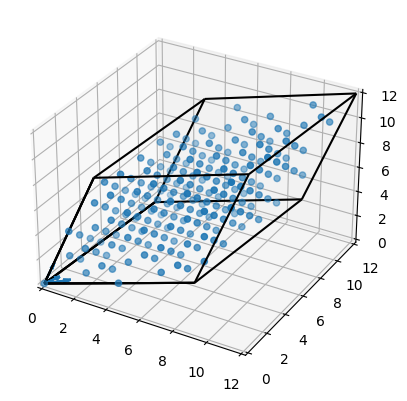

In [21]:
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for ii in range(3):
    X = np.zeros(3)
    Y = np.zeros(3)
    Z = np.zeros(3)
    V1 = nlat[ii, 0]
    V2 = nlat[ii, 1]
    V3 = nlat[ii, 2]
    ax.quiver(X, Y, Z, V1, V2, V3)

# Plot old positions:
# xcpos = [pos[0] for pos in nR]
# ycpos = [pos[1] for pos in nR]
# zcpos = [pos[2] for pos in nR]
# ax.scatter(xcpos, ycpos, zcpos)

# Draw supercell boundary
for ii in range(3):
    X = np.zeros(3)
    Y = np.zeros(3)
    Z = np.zeros(3)
    V1 = nslat[ii, 0]
    V2 = nslat[ii, 1]
    V3 = nslat[ii, 2]
    ax.quiver(X, Y, Z, V1, V2, V3, color="k", arrow_length_ratio=0)
    for jj in range(2):
        X2 = nslat[ii, 0]
        Y2 = nslat[ii, 1]
        Z2 = nslat[ii, 2]
        V21 = nslat[(ii + 1 + jj) % 3, 0]
        V22 = nslat[(ii + 1 + jj) % 3, 1]
        V23 = nslat[(ii + 1 + jj) % 3, 2]
        ax.quiver(X2, Y2, Z2, V21, V22, V23, color="k", arrow_length_ratio=0)
    for jj in range(1):
        X3 = nslat[ii, 0] + nslat[(ii + 1 + jj) % 3, 0]
        Y3 = nslat[ii, 1] + nslat[(ii + 1 + jj) % 3, 1]
        Z3 = nslat[ii, 2] + nslat[(ii + 1 + jj) % 3, 2]
        V31 = nslat[(ii + 2 + jj) % 3, 0]
        V32 = nslat[(ii + 2 + jj) % 3, 1]
        V33 = nslat[(ii + 2 + jj) % 3, 2]
        ax.quiver(X3, Y3, Z3, V31, V32, V33, color="k", arrow_length_ratio=0)

# Plot new positions:
xcspos = [pos[0] for pos in nsR]
ycspos = [pos[1] for pos in nsR]
zcspos = [pos[2] for pos in nsR]
ax.scatter(xcspos, ycspos, zcspos)

# Limits
lims = nslat[0, :] + nslat[1, :] + nslat[2, :]
ax.set_xlim([0, lims[0]])
ax.set_ylim([0, lims[1]])
ax.set_zlim([0, lims[2]])
plt.show()
# for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)